In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from sklearn.utils.class_weight import compute_class_weight

In [4]:
def lr_schedule(epoch):
    initial_lr = 0.001 
    drop = 0.5  
    epochs_drop = 10 
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return max(lr,0.0001)

In [5]:
def constant_to_tensor(x, dtype):
    
    return tf.constant(x, dtype=dtype)

In [6]:
def focal_categorical_crossentropy(target,output,alpha = 1.0,gamma = 2.0,axis = -1):
    
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    target.shape.assert_is_compatible_with(output.shape)
    output = output / tf.reduce_sum(output, axis=axis, keepdims=True)

    epsilon_ = constant_to_tensor(1e-7, output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)

    # Calculate cross entropy
    cce = -target * tf.math.log(output)

    # Calculate factors
    modulating_factor = tf.pow(1.0 - output, gamma)
    weighting_factor = tf.multiply(modulating_factor, alpha)

    # Apply weighting factor
    focal_cce = tf.multiply(weighting_factor, cce)
    focal_cce = tf.reduce_sum(focal_cce, axis=axis)
    return focal_cce

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
main_path = os.getcwd() + '/covid_data'

train_dataset = train_datagen.flow_from_directory(
    directory= main_path + '/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=None)

val_dataset = val_datagen.flow_from_directory(
    directory = main_path + '/validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=None)

test_dataset = test_datagen.flow_from_directory(
    directory = main_path + '/test',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=None)

Found 14811 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [10]:
for image_batch, labels_batch in train_dataset:
  print('Image Shape: {}'.format(image_batch.shape))
  print('Label Shape: {}'.format(labels_batch.shape))
  break

Image Shape: (32, 224, 224, 3)
Label Shape: (32, 4)


In [11]:
class_weights = np.round(compute_class_weight('balanced',classes = np.arange(train_dataset.num_classes),y = train_dataset.labels),2)
class_weights_dict = dict(zip(np.arange(train_dataset.num_classes), class_weights))

In [12]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    base_model = VGG16(weights='imagenet', include_top=False)


    for layer in base_model.layers:
        layer.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation = 'relu')(x)
    x= Dense(1024,activation = 'relu')(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(), loss=focal_categorical_crossentropy, metrics=['categorical_accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset,  epochs=75,callbacks = [LearningRateScheduler(lr_schedule),early_stopping])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/75
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:loc

463/463 [==============================] - 97s 210ms/step - loss: 0.0397 - categorical_accuracy: 0.9438 - val_loss: 0.1048 - val_categorical_accuracy: 0.9103


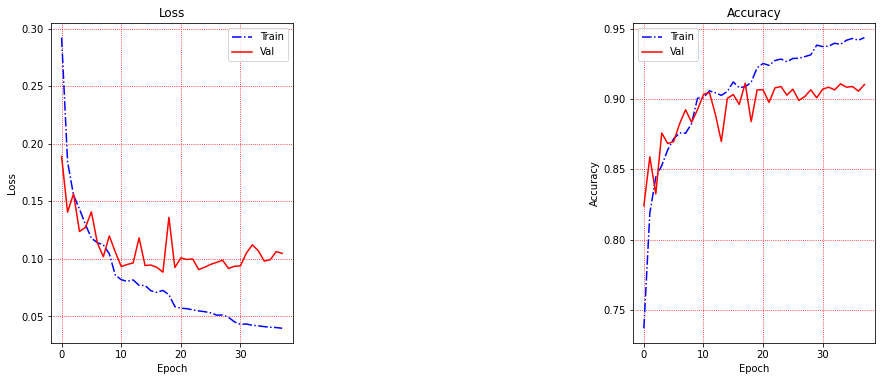

In [13]:
plt.figure(figsize = (20, 20))
plt.subplot(341)
plt.plot(history.history['loss'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_loss'], color='red', linestyle="solid", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

plt.subplot(343)
plt.plot(history.history['categorical_accuracy'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_categorical_accuracy'], color='red', linestyle="solid", label='Val')
# plt.xticks(np.arange(0, 31, step=2))  # Set label locations.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

In [14]:
test_result = model.evaluate(test_dataset, batch_size = 32)

133/133 [==============================] - 28s 205ms/step - loss: 0.0974 - categorical_accuracy: 0.8942


In [15]:
print('Test Loss: {}'.format(test_result[0]))
print('Test Accuracy: {}'.format(test_result[1]))

Test Loss: 0.09740816801786423
Test Accuracy: 0.8942148685455322


In [16]:
class_names = list(train_dataset.class_indices)

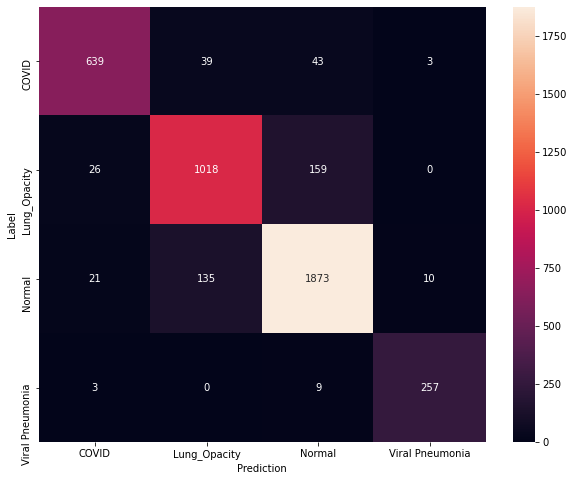

In [17]:
label_names = class_names
y_pred = model.predict(test_dataset, batch_size=128)
y_test = test_dataset.labels
cm = tf.math.confusion_matrix(y_test, 
                              y_pred.argmax(axis=1),
                              num_classes = 4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
              annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('CM.png', dpi = 300)
plt.show()